# Photometry

> Author: *Valentin Christiaens*  
> Package dependencies: astropy, matplotlib, numpy, photutils, scikit-image, scipy
>
> Install with `pip install -r requirements.txt`
> 
> Last update: *2025/04/10*

---

## Table of contents

* [1. Aperture photometry of point sources](#1.-Aperture-photometry-of-point-sources)
    - [1.1. General procedure](#1.1.-General-procedure)
    - [1.2. Apertures](#1.2.-Apertures)
    - [1.3. Error estimation](#1.3.-Error-estimation)
    - [1.4. Aperture photometry with sky coordinates](#1.4.-Aperture-photometry-with-sky-coordinates)
* [2. Background subtraction](#2.-Background-subtraction)
    - [2.1. Constant value](#2.1.-Constant-value)
    - [2.2. Annular estimate](#2.2.-Annular-estimation)
    - [2.3. Gradient estimate](#2.3.-Gradient-estimate)
* [3. Source identification](#3.-Source-identification)
    - [3.1. Centroid measurement](#3.1.-Centroid-measurement)
    - [3.2. Image alignment](#3.2.-Image-alignment)
    - [3.3. Automatic source finding](#3.3.-Automatic-source-finding)

---

In this lecture, we will see how to carry out the photometry (i.e. quantify the brightness) of point sources in astronomical images.

Before the advent of gravitational wave astronomy, *all* we knew about our Universe came from measuring the light of celestial objects. Chronologically: measurements were first made by eye (through an eyepiece after the invention of the telescope); then through photographic plates placed in the focal plane of the telescope; and more recently through electronic detectors (charge-coupled devices; CCD). 

**Photometry** is the act of counting photons. Different instruments can be placed in the focal plane of a telescope to measure photon counts.
- Imagers (i.e. camera/detectors) provide the image of a field in which a number of sources may be located, and with different sources contributing the photon counts of different **pixels** in the image. A *filter* is typically set in the optical path of the instrument to define a wavelength bandpass over which photons can . A [**photometric system**](https://en.wikipedia.org/wiki/Photometric_system) is a standard set of filters used from optical to infrared wavelengths.
- Spectrographs are instruments dispersing the light coming from a given field-of-view before it hits the detector, and can come with various designs.
Some spectrograph designs enable the simultaneous acquisition of multi-wavelength images (e.g. integral field spectrographs). The task of measuring photons in images at different wavelengths is then referred to as **spectro-photometry**.

Note that high-spectral resolution spectrographs (e.g. Echelle spectrographs) typically do not provide spatial information - all the incoming light is dispersed. The outcome then takes the form of a 1D spectrum for the observed object/field.

**Goals of this lecture:** 

1. Be able to measure the photometry of point sources.
2. Be able to estimate and subtract the background contribution.
3. Know how to identify sources and measure their centroid location.
4. Know how to register observed images before stacking them.

In [3]:
# Let's import modules we will use a lot in this tutorial:
from matplotlib import pyplot as plt
import numpy as np

## 1. Aperture photometry of point sources

The most direct way to quantify the brightness of sources in astronomical images is to perform **aperture photometry**, that is to count and sum the number of photon hits on pixels within a given aperture encompassing the source.

The size of the aperture should be well chosen to either capture most of the flux of the star, or a well-characterized fraction of the whole incoming flux. Calibration observations of standard sources (e.g. non-variable bright stars) typically enable to define a radius which correspond to 50% or 80% of all the incoming energy. Using such radius for the photometry of a science source, one can then correct for the missing flux not encompassed in the aperture. This is called **aperture correction**.

The package offering the most options for aperture photometry is the Astropy-affiliated package `photutils`.

The `aperture_photometry()` function and the `ApertureStats` class are the main tools to perform aperture photometry on an astronomical image for a given set of apertures.

Photutils provides several apertures defined in pixel or sky coordinates. The aperture classes that are defined in pixel coordinates are:

- `CircularAperture`
- `CircularAnnulus`
- `EllipticalAperture`
- `EllipticalAnnulus`
- `RectangularAperture`
- `RectangularAnnulus`

Each of these classes has a corresponding variant defined in sky coordinates:

- `SkyCircularAperture`
- `SkyCircularAnnulus`
- `SkyEllipticalAperture`
- `SkyEllipticalAnnulus`
- `SkyRectangularAperture`
- `SkyRectangularAnnulus`

To perform aperture photometry with sky-based apertures, one needs to specify a WCS transformation.

### 1.1. General procedure

The first step in performing aperture photometry with `photutils` is to create an **aperture object**. An aperture object is defined by a position (or a list of positions) and parameters that define its size and possibly, orientation (e.g., for an elliptical aperture).

**Example**: Let's create a circular aperture in pixel coordinates using the `CircularAperture` class:

In [4]:
from photutils.aperture import CircularAperture

aperture = CircularAperture((30, 30), r=3.0)

After the aperture object is created, we can perform the photometry using the `aperture_photometry()` function, providing it both the data and the aperture(s).

**Example:** Let's consider an array of all ones and integrate the flux over the apertures defined above. 

In [5]:
from photutils.aperture import aperture_photometry

image = np.ones((100, 100))
phot_table = aperture_photometry(image, aperture)

In [6]:
#phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1    30.0    30.0 28.274333882308134


This function returns the results of the photometry in an Astropy **QTable**. In this example, the table has four columns, named 'id', 'xcenter', 'ycenter', and 'aperture_sum'.

Since all the data values are 1.0, the aperture sum is equal to the area of a circle with a radius of 3:

In [5]:
print(np.pi * 3.0**2)

28.274333882308138


### 1.2. Apertures

Let's assume we want to consider several apertures at once:

In [6]:
from photutils.aperture import CircularAperture

positions = [(30.0, 30.0), (40.0, 40.0)]
apertures = CircularAperture(positions, r=3.0)

The positions should be either a single tuple of (x, y) - as seen in the previous section - or a list of (x, y) tuples, or an array with shape Nx2, where N is the number of positions.

The above example defines two circular apertures with a radius of 3 pixels, and located at pixel coordinates (30, 30) and (40, 40).

In [7]:
phot_table = aperture_photometry(data, apertures)
print(phot_table)

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1    30.0    30.0 28.274333882308134
  2    40.0    40.0 28.274333882308134


One can also consider a list of apertures, for example with **multiple aperture sizes**:

In [8]:
radii = [3.0, 4.0, 5.0]
apertures = [CircularAperture(positions, r=r) for r in radii]

In [9]:
phot_table = aperture_photometry(data, apertures)
print(phot_table)

 id xcenter ycenter   aperture_sum_0     aperture_sum_1    aperture_sum_2 
      pix     pix                                                         
--- ------- ------- ------------------ ----------------- -----------------
  1    30.0    30.0 28.274333882308134 50.26548245743669 78.53981633974485
  2    40.0    40.0 28.274333882308134 50.26548245743669 78.53981633974485


<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 1.1:** Measure the aperture photometry of star HD 135344 B ('data/SPHERE_PSF_HD135.fits') in detector units for different, increasing, aperture sizes (from 1 to 80 pixels by steps of 1). Make a plot of the measured flux as a function of aperture size, and estimate the aperture radius which encompasses half of the total energy.

Tip: here it is fine to consider the coordinates of the peak intensity pixel for the center of the aperture.
</div>

Find the closest aperture to 50%:

**Alternative** (shortcut) method using `CurveOfGrowth` to plot the profile:

### 1.3. Error estimation

If and only if the `error` keyword is input to `aperture_photometry()`, the returned table will include a 'aperture_sum_err' column in addition to 'aperture_sum'. 'aperture_sum_err' provides the propagated uncertainty associated with 'aperture_sum'.

**Example:**

In [7]:
positions = [(30.0, 30.0), (40.0, 40.0)]
aperture = CircularAperture(positions, r=3.0)
data = np.ones((100, 100))
error = 0.1 * data

In [8]:
phot_table = aperture_photometry(data, aperture, error=error)

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output: force 8 significant digits
    
print(phot_table)

 id xcenter ycenter aperture_sum aperture_sum_err
      pix     pix                                
--- ------- ------- ------------ ----------------
  1      30      30    28.274334       0.53173616
  2      40      40    28.274334       0.53173616


### 1.4. Aperture photometry with sky coordinates

Analogous to detector-based apertures, one can also define apertures in sky coordinates:

- `SkyCircularAperture`
- `SkyCircularAnnulus`
- `SkyEllipticalAperture`
- `SkyEllipticalAnnulus`
- `SkyRectangularAperture`
- `SkyRectangularAnnulus`


Creating an aperture object in sky coordinates is straightforward. One first uses the `SkyCoord` class to define sky coordinates and then the `SkyCircularAperture` class to define the aperture object:

In [9]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils.aperture import SkyCircularAperture

positions_sky = SkyCoord(l=[1.2, 2.3] * u.deg, b=[0.1, 0.2] * u.deg, frame='galactic')

aperture_sky = SkyCircularAperture(positions_sky, r=4.0 * u.arcsec)

Then to perform aperture photometry with sky-based apertures, one needs to specify a WCS transformation.

**Example:** Let's measure the photometry of sources in a Spitzer 4.5 micron image of a region of the Galactic plane.

In [10]:
import astropy.units as u
from astropy.wcs import WCS
from photutils.datasets import load_spitzer_catalog, load_spitzer_image

spitzer_hdu = load_spitzer_image()
spitzer_image = spitzer_hdu.data
data = u.Quantity(spitzer_image, unit=spitzer_hdu.header['BUNIT'])  
wcs = WCS(spitzer_hdu.header)

catalog = load_spitzer_catalog()  

Let's visualize the Spitzer image:

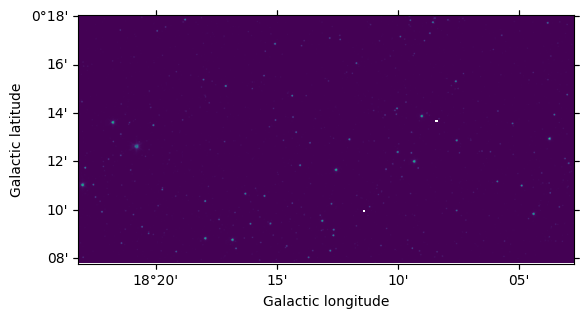

In [26]:
ax = plt.subplot(projection=wcs)   # This initialises your axes transforming it to WCS 
ax.imshow(spitzer_image, origin='lower')
#ax.grid(color='white', ls='solid')
ax.set_xlabel('Galactic longitude')
ax.set_ylabel('Galactic latitude')

The catalog contains (among other things) the Galactic coordinates of the sources in the image as well as the PSF-fitted fluxes from the official Spitzer data reduction. We define the apertures positions based on the existing catalog positions:

In [14]:
from astropy.coordinates import SkyCoord

positions = SkyCoord(catalog['l'], catalog['b'], frame='galactic')
positions

<SkyCoord (Galactic): (l, b) in deg
    [(18.384317, 0.240381), (18.38085 , 0.205   ), (18.383131, 0.264819),
     (18.380336, 0.264739), (18.343074, 0.298394), (18.357916, 0.289592),
     (18.335555, 0.299889), (18.331838, 0.168944), (18.328968, 0.180003),
     (18.338055, 0.207464), (18.365955, 0.200944), (18.323746, 0.205164),
     (18.325762, 0.152619), (18.369547, 0.199272), (18.297193, 0.182172),
     (18.26296 , 0.165625), (18.287281, 0.187772), (18.376408, 0.183389),
     (18.268067, 0.171606), (18.32424 , 0.200425), (18.272457, 0.146708),
     (18.244035, 0.14025 ), (18.319371, 0.137411), (18.303915, 0.165328),
     (18.228162, 0.133453), (18.350741, 0.193439), (18.289887, 0.159442),
     (18.383536, 0.267539), (18.369578, 0.195869), (18.37051 , 0.164739),
     (18.243204, 0.141297), (18.340549, 0.202839), (18.266835, 0.147172),
     (18.348458, 0.271067), (18.362683, 0.213017), (18.328835, 0.181231),
     (18.363153, 0.268356), (18.295699, 0.159111), (18.374925, 0.174878),
  

In [15]:
aperture = SkyCircularAperture(positions, r=4.8 * u.arcsec)

Now perform the photometry with these apertures on the data, through the wcs object for conversion from sky to pixel coordinates:

In [13]:
phot_table = aperture_photometry(data, aperture, wcs=wcs)

The wcs object contains the WCS transformation of the image obtained from the FITS header. It includes the coordinate frame of the image and the projection from sky to pixel coordinates. The `aperture_photometry` function uses the WCS information to convert apertures defined in sky coordinates into pixel coordinates.

In [17]:
import astropy.units as u

factor = (1.2 * u.arcsec)**2 / u.pixel
converted_aperture_sum = (phot_table['aperture_sum'] * factor).to(u.mJy / u.pixel)

Finally, we can load the photometry from the catalog, and plot the comparison with our manually retrieved photometry:

In [18]:
fluxes_catalog = catalog['f4_5']  

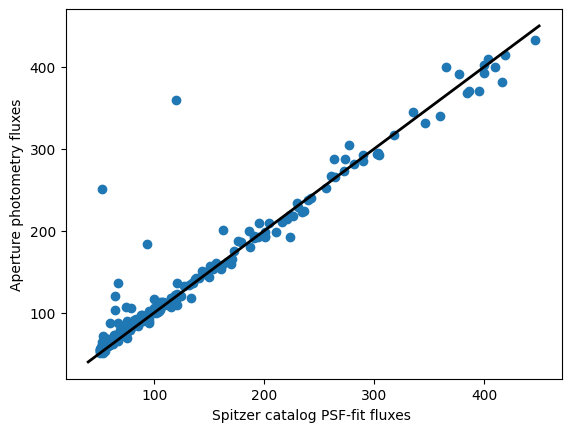

In [19]:
import matplotlib.pyplot as plt
plt.scatter(fluxes_catalog, converted_aperture_sum.value)
plt.xlabel('Spitzer catalog PSF-fit fluxes ')
plt.ylabel('Aperture photometry fluxes')
plt.plot([40, 100, 450], [40, 100, 450], color='black', lw=2)

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 2.1:** Read in the file `data/HelixNebula.fits` and:

1. Define a SkyCoord object containing the sky coordinates of the Helix nebula.
2. Measure the integrated flux at these sky coordinates in the image. Consider an aperture of 15 arcmin radius.

</div>

## 2. Background subtraction

By default `aperture_photometry()` assumes that the input data have been background-subtracted. Nonetheless typical observations also capture (diffuse) background emission which needs to be subtracted to not bias the photometry of objects of interest.

Ground-Based Telescope (GBT) thermal emission is by far the dominant contributor at wavelengths > 2 µm, while both OH airglow and Zodiacal Scattered Light (ZSL; sunlight scattered by interplanetary dust) can affect deep optical and near IR observations at shorter wavelengths:

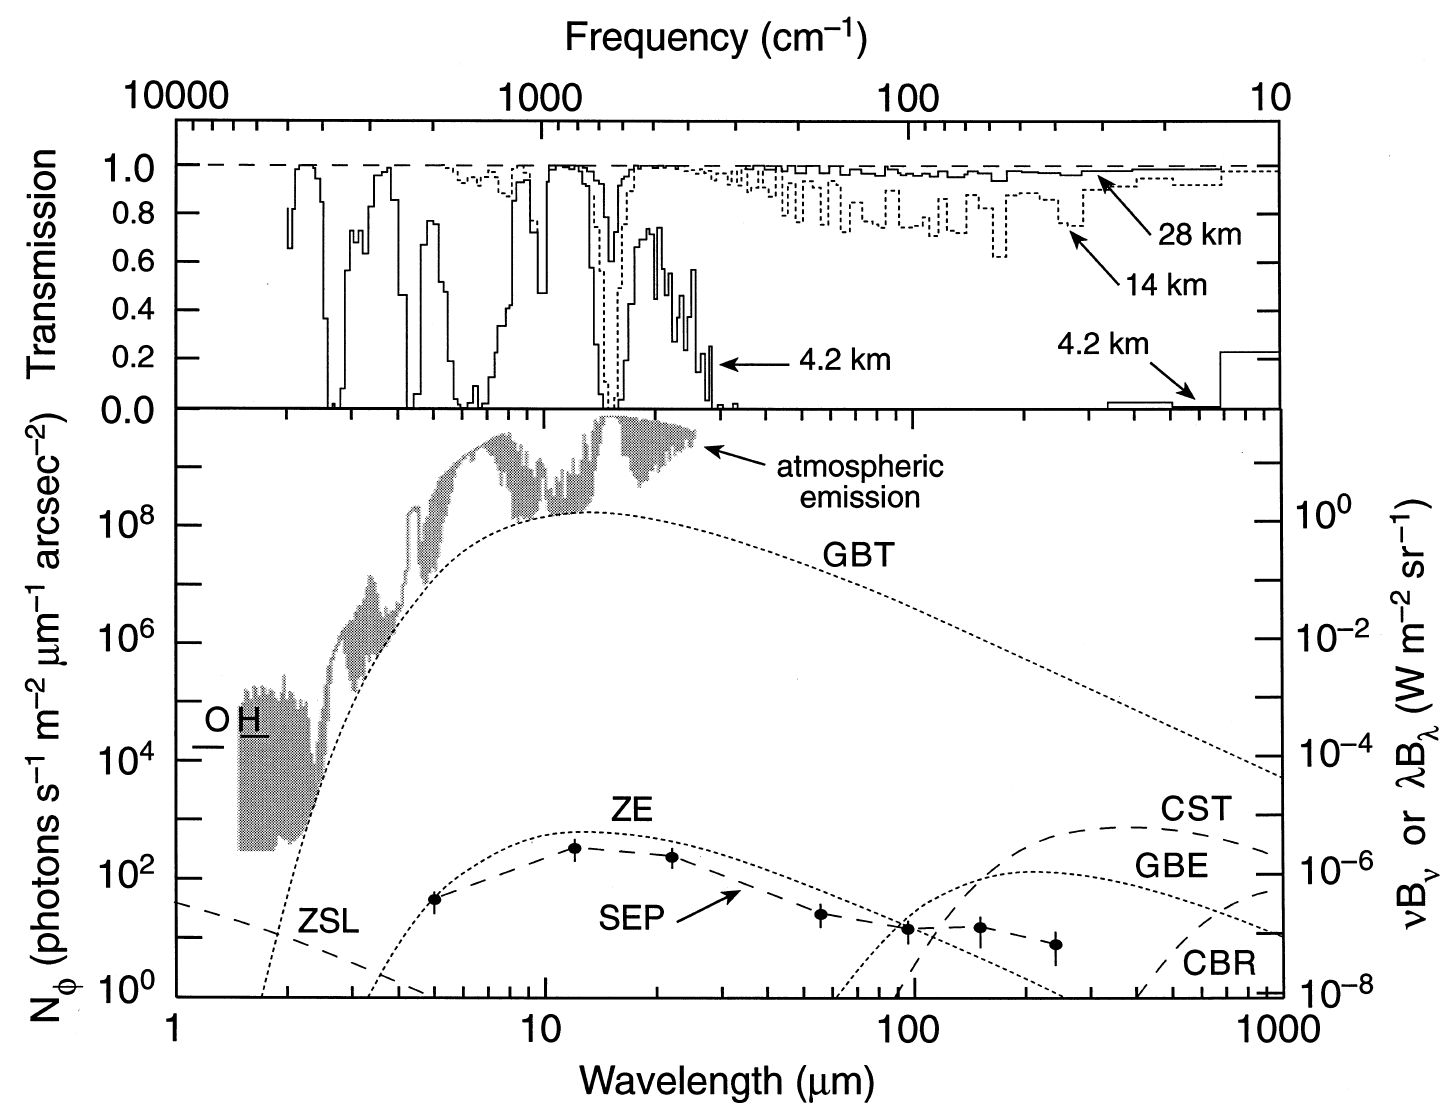

Besides GBT, only specific atmospheric transmission bands enable IR astronomy from the ground -- which together have motivated IR space telescopes like ISO, Spitzer or JWST. Space-based observations are not devoid of background: Zodiacal Emission (ZE) dominates at Mid-IR wavelengths, while Galactic Background Emission (GBE) and emission from the telescope itself, even if cooled by a cryostat system (CST=Cryogenic-cooled Space Telescope) dominate at Far IR wavelengths.

Depending on the wavelength of your observation and the brightness of your object, it may be crucial to subtract an appropriate background estimate before being able to carry out accurate photometry. Let's see how this can be done:

### 2.1. Constant value

If `bkg` is either a float value or an array representing the background in the data (e.g., determined by `Background2D`, see Sec. 2.3), one can simply subtract the background from the data before aperture photometry:

In [20]:
data = np.ones((100, 100))
bkg = 0.1
aperture = CircularAperture((30, 30), r=3.0)

phot_table = aperture_photometry(data - bkg, aperture) 
print(phot_table)

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1    30.0    30.0 25.446900494077326


A very convenient function to estimate the mean background level is `sigma_clipped_stats`. It will calculate image statistics on pixels whose intensity is below a certain threshold set by median +- sigma*standard_deviation, where `sigma` is set by the user.

**Example:** Let's estimate the background in the Spitzer image

In [21]:
from astropy.stats import sigma_clipped_stats

mean_bkg, median_bkg, std_bkg = sigma_clipped_stats(spitzer_image, sigma=3.0)

print((mean_bkg , median_bkg , std_bkg )) 

(4.286413, 3.836381, 1.6192979)


Given the potential presence of outliers, it is better to take the median as background proxy.

One can notice that lowering the sigma threshold to reject outliers also lowers the mean/median background level:

In [22]:
from astropy.stats import sigma_clipped_stats

mean_bkg , median_bkg, std_bkg  = sigma_clipped_stats(spitzer_image, sigma=2.5)

print((mean_bkg , median_bkg , std_bkg)) 

(4.042252, 3.7515738, 1.2752802)


<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 2.2:** Read in the file `data/M13_blue_0001.fits` and:

1. Estimate and subtract the background from the image.
2. Measure the flux for the brightest point source in the M13 field in a 4 pixel-radius aperture, including error. Assume Poisson noise uncertainties (i.e. that detector units correspond to photon counts).

</div>

### 2.2. Annular estimate

One often wants to also estimate the **local background** around each source using a nearby aperture or annulus aperture surrounding each source. A simple method for doing this is to use the `ApertureStats` class to compute the mean background level within the background aperture. This class can also be used to calculate more advanced statistics (e.g., a sigma-clipped median) within the background aperture (e.g., a circular annulus).

**Examples:** Let's first generate a more realistic dataset.

In [29]:
from photutils.datasets import make_100gaussians_image

data = make_100gaussians_image()

This artificial image has a known average background level of 5. Let's see if local background estimation manages to get rid of that contribution.

For this example we perform the photometry for three sources in a circular aperture with a radius of 5 pixels. The local background level around each source is estimated using a circular annulus of inner radius 10 pixels and outer radius 15 pixels. Let’s define the apertures:

In [30]:
from photutils.aperture import CircularAnnulus, CircularAperture

positions = [(145.1, 168.3), (84.5, 224.1), (48.3, 200.3)]

aperture = CircularAperture(positions, r=5) # for source
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15) # for background

Now let’s plot the circular apertures (white) and circular annulus apertures (red) on a cutout from the image containing the three sources:

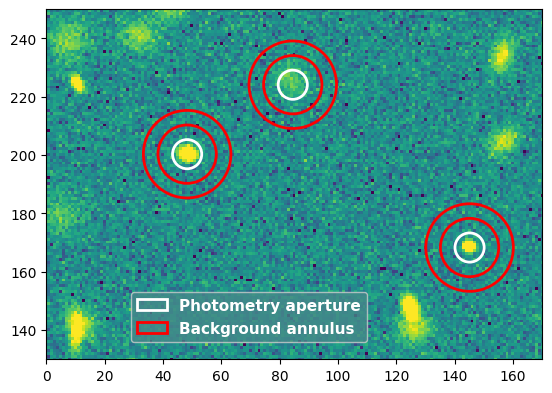

In [31]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm

norm = simple_norm(data, 'sqrt', percent=99)  # sqrt (square root) is an alternative to linear or log stretch
plt.imshow(data, norm=norm, interpolation='nearest')
plt.xlim(0, 170)
plt.ylim(130, 250)

ap_patches = aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
ann_patches = annulus_aperture.plot(color='red', lw=2,
                                    label='Background annulus')
handles = (ap_patches[0], ann_patches[0])
plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})

We can use the `ApertureStats` class to compute the mean background level within the annulus aperture at each position:

In [34]:
from photutils.aperture import ApertureStats

aperstats = ApertureStats(data, annulus_aperture)
bkg_mean = aperstats.mean
print(bkg_mean)  

[4.96369499 5.10467691 4.9497741 ]


Close enough!

These are mean background values, so need to be scaled by the size of the aperture used for aperture photometry of the source in order to subtract the total expected contribution from the background.

In [35]:
phot_table = aperture_photometry(data, aperture)

print(aperture.area)
total_bkg = bkg_mean * aperture.area
phot_bkgsub = phot_table['aperture_sum'] - total_bkg

78.53981633974483


Let's finally add the background estimates and background subtracted photometry to the table:

In [36]:
phot_table['total_bkg'] = total_bkg
phot_table['aperture_sum_bkgsub'] = phot_bkgsub
print(phot_table)

 id xcenter ycenter    aperture_sum        total_bkg      aperture_sum_bkgsub
      pix     pix                                                            
--- ------- ------- ------------------ ------------------ -------------------
  1   145.1   168.3 1131.5794219396346 389.84769319186995   741.7317287477647
  2    84.5   224.1   746.160643858321  400.9203872081304   345.2402566501906
  3    48.3   200.3 1250.2185660077996 388.75434842744687   861.4642175803527


<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 2.3.:** Measure the flux for the 3 brightest point sources in the Spitzer image, after subtracting the estimated background level in a surrouding annulus. Consider appropriate values for the respective radii of the aperture and annulus. Beware of the presence of NaN values.

Tip: find the 3 brightest sources based on the Spitzer catalog loaded previously, considering that the image was taken at 4.5 µm.

</div>

### 2.3. Gradient estimate

More advanced tools to estimate 2D background images are also available in photutils. Most are based on a masking of the brightest sources (in a similar fashion as `sigma_clipped_stats`) followed by a smoothing (low-pass spatial filter) of the images.

**Example:** Let's make 100 Gaussian sources and add a smooth background gradient:

In [37]:
from photutils.datasets import make_100gaussians_image
data = make_100gaussians_image()

In [38]:
# add a gradient background to the data

ny, nx = data.shape
y, x = np.mgrid[:ny, :nx]
gradient = x * y / 5000.0
data2 = data + gradient

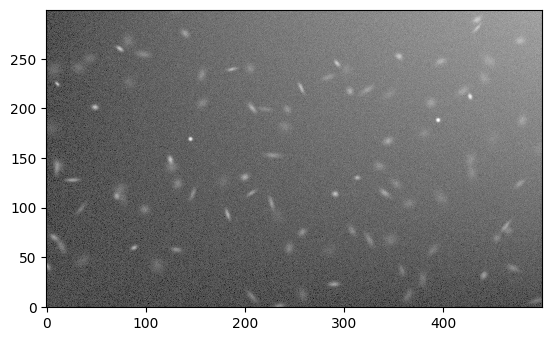

In [39]:
# visualize
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data2, norm=norm, origin='lower', cmap='Greys_r',
           interpolation='nearest')

To estimate the background, let's create a `Background2D` object using a moving box of size 50x50 px. We will estimate the background level in each box of the mesh as the sigma-clipped median using an instance of `MedianBackground`.

In [56]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground

sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(data2, (50, 50), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

Let’s plot the estimated background image:

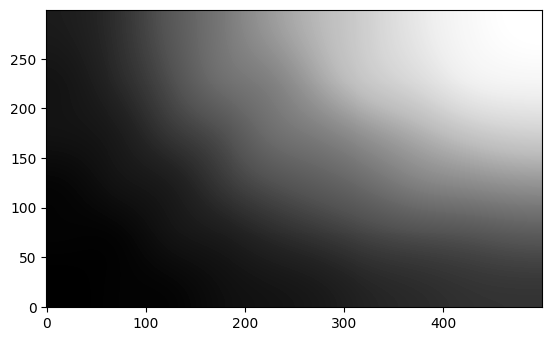

In [57]:
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',
           interpolation='nearest')

And the background-subtracted image:

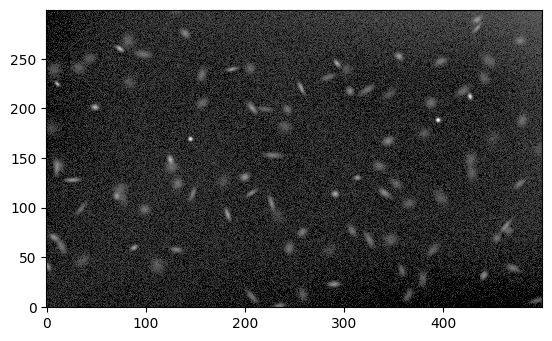

In [58]:
plt.imshow(data2 - bkg.background, norm=norm, origin='lower',
           cmap='Greys_r', interpolation='nearest')

Additional background estimation and subtraction methods available in `photutils` are described on [this page](https://photutils.readthedocs.io/en/stable/background.html).

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Side note:** In IR astronomy, it is common practice to acquire dedicated background images on empty patches of sky close in time from the science observation in order to estimate and subtract the background. A straightforward approach is to subtract the median of the stack of background images. More advanced approaches can rely on... [PCA](https://ui.adsabs.harvard.edu/abs/2018A%26A...611A..23H/abstract) (cfr. Lecture 03)!
</div>

## 3. Source identification

### 3.1. Centroid measurement

`photutils.centroids` provides several functions to calculate the centroid of a single source:

- `centroid_com`: Calculates the object “center of mass” from 2D image moments.
- `centroid_quadratic`: Calculates the centroid by fitting a 2D quadratic polynomial to the data.
- `centroid_1dg`: Calculates the centroid by fitting 1D Gaussians to the marginal x and y distributions of the data.
- `centroid_2dg`: Calculates the centroid by fitting a 2D Gaussian to the 2D distribution of the data.

Masks can be inputs for each of these functions to mask bad pixels.

Error arrays can be inputs to the two Gaussian fitting methods. These would be used to infer weights (inversely proportional to the error) to use for the different pixel intensities in the fits.

In [109]:
from photutils.datasets import make_4gaussians_image

data = make_4gaussians_image()[43:79, 76:104]

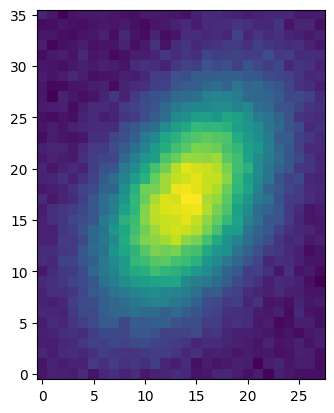

In [110]:
plt.imshow(data, origin='lower')

Let's compare the different methods:

In [111]:
from photutils.centroids import (centroid_1dg, centroid_2dg,
                                 centroid_com, centroid_quadratic)

Coordinates found corresponding to the center of mass (COM) of the image:

In [112]:
x1, y1 = centroid_com(data)
print((x1, y1))

(13.931579983412139, 17.051234441067088)


Coordinates found by fitting a 2D quadratic polynomial:

In [113]:
x2, y2 = centroid_quadratic(data)
print((x2, y2))  

(13.948284438186942, 16.987881994357604)


Coordinates found by fitting a 1D Gaussian:

In [114]:
x3, y3 = centroid_1dg(data)
print((x3, y3))

(14.040352707371394, 16.962306463644794)


Coordinates found by fitting a 2D Gaussian:

In [115]:
x4, y4 = centroid_2dg(data)
print((x4, y4))

(14.00221339471489, 16.99613641931417)


<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Side note:** Alternatives to the `photutils.centroids` routines are the [2D model fitting utilities in Astropy](
https://docs.astropy.org/en/stable/modeling/fitting.html#simple-2-d-model-fitting). These include a wider choice of models including also 2D Moffat or 2D Airy function.
</div>

Let's plot the results. Since they are all similar, let's include an inset to zoom on the inferred centroids:

(0.0, 35.0)

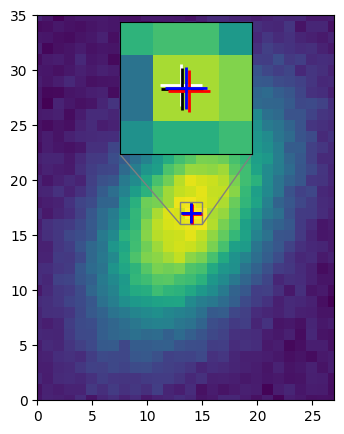

In [116]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import (mark_inset,
                                                   zoomed_inset_axes)
from photutils.centroids import (centroid_1dg, centroid_2dg,
                                 centroid_com, centroid_quadratic)
from photutils.datasets import make_4gaussians_image

data = make_4gaussians_image()[43:79, 76:104]  # extract single object
xycen1 = centroid_com(data)
xycen2 = centroid_quadratic(data)
xycen3 = centroid_1dg(data)
xycen4 = centroid_2dg(data)
xycens = [xycen1, xycen2, xycen3, xycen4]
fig, ax = plt.subplots(1, 1, figsize=(4, 5))
ax.imshow(data, origin='lower', interpolation='nearest')
marker = '+'
ms, mew = 15, 2.0
colors = ('white', 'black', 'red', 'blue')
for xycen, color in zip(xycens, colors):
    plt.plot(*xycen, color=color, marker=marker, ms=ms, mew=mew)

ax2 = zoomed_inset_axes(ax, zoom=6, loc=9)
ax2.imshow(data, vmin=190, vmax=220, origin='lower',
           interpolation='nearest')
ms, mew = 30, 2.0
for xycen, color in zip(xycens, colors):
    ax2.plot(*xycen, color=color, marker=marker, ms=ms, mew=mew)
ax2.set_xlim(13, 15)
ax2.set_ylim(16, 18)
mark_inset(ax, ax2, loc1=3, loc2=4, fc='none', ec='0.5')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax.set_xlim(0, data.shape[1] - 1)
ax.set_ylim(0, data.shape[0] - 1)

To calculate the centroids of many sources in an image, use the `centroid_sources()` function. This function can be used with any of the  centroiding functions presented above (`centroid_com`, `centroid_quadratic`, `centroid_1dg`, or `centroid_2dg`), or a custom user-defined centroiding function.

### 3.2. Image alignment

A common task required before stacking astronomical images is to **align them** first. There is indeed always some jitter. An appropriate approach is to search for shifts that maximize the pair-wise cross-correlation between images of the stack.

`scikit-image` has a routine to do this, based on maximimizing cross-correlation in the Fourier plane: `phase_cross_correlation`.

**Example 1:** Pixel-precision alignment.

Known offset (y, x): (-22.4, 13.32)


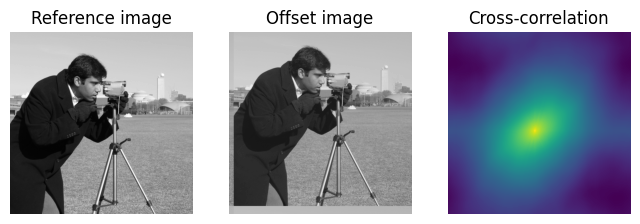

Detected pixel offset (y, x): [ 22. -13.]


In [117]:
from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

image = data.camera()
shift = (-22.4, 13.32)
# The shift corresponds to the pixel offset relative to the reference image
offset_image = fourier_shift(np.fft.fftn(image), shift)
offset_image = np.fft.ifftn(offset_image)
print(f'Known offset (y, x): {shift}')

# pixel precision first
shift, error, diffphase = phase_cross_correlation(image, offset_image)  # with noisy images it is recommended to add: "normalization=None"

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product)) # fftshift recenters the inverse fft image
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print(f'Detected pixel offset (y, x): {shift}')

The shift of the peak of the cross-correlation with respect to the center indicates the relative shift between images.

For sub-pixel accuracy shifts, it is recommended to increase `upsample_factor` (e.g. `upsample_factor=100` means a requested precision of 1/100 pixel; increasing this parameter also makes it slower).

For noisy images, it is recommended to set `normalization=False`.

**Example 2:** Sub-pixel precision alignment.

In [118]:
# subpixel precision
shift, error, diffphase = phase_cross_correlation(image, offset_image,
                                                  upsample_factor=100)  # with noisy images it is recommended to add: "normalization=None"

print(f'Detected subpixel offset (y, x): {shift}')

Detected subpixel offset (y, x): [ 22.4  -13.32]


<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 3.1:** Load all 5 images of M13 (`'M13_blue_000n.fits'`), then:

1. Try to estimate and subtract the background using a couple of methods that you deem fitting. Which method works the best?
2. Try to align the images with respect to the first one based on either (i) the center of mass or (ii) pair-wise cross-correlation. Which method works the best?
3. Stack the aligned images and write a new FITS file, including a modified header.

Tip 1: the best solution for background subtraction in this case may not be an approach seen above, but can be inferred from careful inspection of the structure of the background signal.

Tip 2: use the `shift` function from `scipy.ndimage` for subpixel shifts. Basic usage: `shifted_image = shift(image, (shift_y, shift_x))`. As usual more info in dosctrings.

</div>

### 3.3. Automatic source finding

`Photutils` includes two widely-used tools that are used to detect stars in an image, DAOFIND and IRAF’s starfind, plus a third tool that allows input of a custom user-defined kernel. More details on them are available [here](https://photutils.readthedocs.io/en/stable/detection.html).

**Example:**

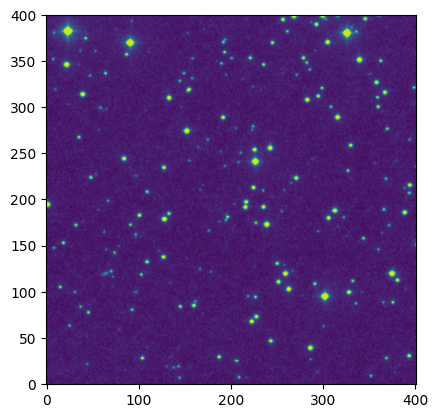

In [119]:
from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image

hdu = load_star_image()  
data = hdu.data[0:401, 0:401] 

plt.imshow(data, origin='lower')

In [120]:
mean, median, std = sigma_clipped_stats(data, sigma=3.0)  
print((mean, median, std))

(3668.09661145823, 3649.0, 204.41388592022315)


Now we will subtract the background and use an instance of DAOStarFinder to find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background. Running this class on the data yields an astropy Table containing the results of the star finder:

In [121]:
from photutils.detection import DAOStarFinder
daofind = DAOStarFinder(fwhm=3.0, threshold=5.*std)  
sources = daofind(data - median)

for col in sources.colnames:  
    if col not in ('id', 'npix'):
        sources[col].info.format = '%.2f'  # for consistent table output
        
sources.pprint(max_width=76)  

 id xcentroid ycentroid sharpness roundness1 ... sky    peak  flux  mag 
--- --------- --------- --------- ---------- ... ---- ------- ---- -----
  1    144.25      6.38      0.58       0.20 ... 0.00 6903.00 5.70 -1.89
  2    208.67      6.82      0.48      -0.13 ... 0.00 7896.00 6.72 -2.07
  3    216.93      6.58      0.69      -0.71 ... 0.00 2195.00 1.67 -0.55
  4    351.63      8.55      0.49      -0.34 ... 0.00 6977.00 5.90 -1.93
  5    377.52     12.07      0.52       0.37 ... 0.00 1260.00 1.12 -0.12
  6    294.27     12.74      0.68       0.11 ... 0.00 2059.00 1.48 -0.43
  7     85.22     14.71      0.62      -0.93 ... 0.00 1458.00 1.25 -0.24
  8    137.94     17.46      0.54       0.10 ... 0.00 5451.00 4.68 -1.68
  9    130.33     18.68      0.63       0.18 ... 0.00 3432.00 2.86 -1.14
 10    143.11     18.62      0.52       0.08 ... 0.00 6722.00 5.76 -1.90
 11    382.68     19.49      0.62      -0.31 ... 0.00 1350.00 1.34 -0.32
 12     44.35     21.28      0.59       0.22 ... 0.

Let’s plot the image and mark the location of detected sources:

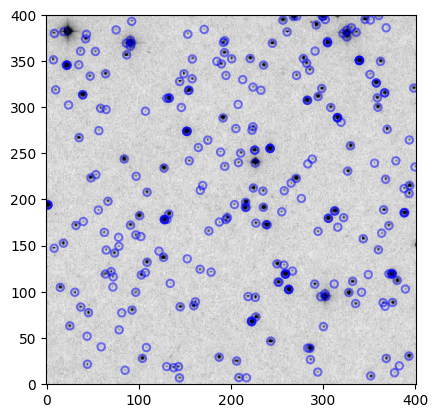

In [122]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())

plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Exercise 3.2:** Take the image of the Horsehead nebula (`'data/HorseHead.fits'`):

1. Automatically find stars in the HorseHead nebula image,
2. Overplot circles at their location,
3. Estimate the Poisson noise affecting each pixel (assume they trace photon counts), 
4. Measure the aperture photometry of the stars including Poisson noise uncertainties, and after subtracting annular estimates of the background.

</div>

<a class="anchor" id="det1"></a> <div class="alert alert-block alert-warning"> 
**Side note:** In this lecture, we only considered the case of measuring the photometry of unresolved point sources. For **extended elliptical sources** (e.g. galaxies) it is common to use **isophotes** instead. The interested reader can refer to the [following instructions](https://photutils.readthedocs.io/en/stable/isophote.html) explaining how to use the tools available in `photutils` in such case. A more general, yet very convenient, `photutils` tool can also provide the [morphological properties](https://photutils.readthedocs.io/en/stable/user_guide/morphology.html) of the intensity distribution.
</div>

[Go back to top](#Table-of-contents)

## References

- This notebook is mostly based on the astropy tutorials available [here](https://learn.astropy.org/).
- Your reference for using `astropy` should be the [online documentation](http://docs.astropy.org/en/latest). Here are links to specific documentation on [quantities](https://docs.astropy.org/en/stable/units/index.html), [constants](https://docs.astropy.org/en/stable/constants/index.html), the [`wcs` module](http://docs.astropy.org/en/stable/visualization/wcsaxes/), [FITS handling](https://docs.astropy.org/en/stable/io/fits/index.html), [`coordinates`](http://docs.astropy.org/en/stable/coordinates/index.html), [`Table` objects](http://docs.astropy.org/en/stable/table/io.html), and [modeling](https://docs.astropy.org/en/stable/modeling/index.html).
- Photutils documentation on [aperture photometry](https://photutils.readthedocs.io/en/stable/aperture.html) and [isophotes](https://photutils.readthedocs.io/en/stable/isophote.html).
- Scikit-image documentation on [phase cross-correlation](https://scikit-image.org/docs/stable/auto_examples/registration/plot_register_translation.html). 

## Credits:

If you use Astropy directly—or as a dependency to another package—for your work, please remember to include the following acknowledgment at the end of papers:

*This research made use of Astropy, a community-developed core Python package for Astronomy (Astropy Collaboration, 2013).*

Where the astropy paper is 2013, A&A, 558, 33 http://adsabs.harvard.edu//abs/2013A%26A...558A..33A

[Go back to top](#Table-of-contents)